# Load libraries

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    %pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [4]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [5]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,0,0.0,1.0,1,0.0,NaN,0.0,0.5
1,15,0,0,0,0,0,0,0.030303,0.083333,0,...,0.0,0.0,1,0.0,0.0,0,0.5,0,0.5,0.0
2,242,0,0,0,0,0,0,NaN,NaN,0,...,1.0,1.0,0,0.5,0.0,0,1.0,0,0.0,0.5
3,1038,0,0,0,0,0,0,NaN,NaN,0,...,0.5,0.5,0,0.0,0.0,0,0.0,0,0.0,0.5
4,971,0,0,0,0,0,0,NaN,NaN,0,...,0.0,0.0,1,0.0,0.5,0,0.0,0,0.0,0.0


# Replace all NaN's in train and test data to most frequent values in train data

In [6]:
Xbig = np.vstack((Xtrain, Xtest))

In [7]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(Xbig)

Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

# Train Random Forest classifier

In [8]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [9]:
from sklearn.metrics import log_loss

In [10]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [11]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.71937529026
0.0549570983773
0.0547685994845
0.0548446140935
0.0546815226363
0.0546449523414
0.0545145962177
0.0544671591684
0.0543776144523
0.0544541962401
4.00991567438
0.247135738393
0.215703630767
0.215540742297
0.215496752921
0.215041600531
0.214913966608
0.214795868871
0.21453084507
0.21424291461


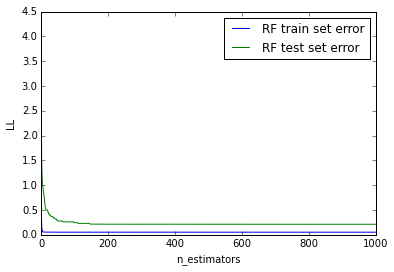

In [34]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

In [13]:
from sklearn.grid_search import GridSearchCV

In [132]:
clf = RandomForestClassifier(n_estimators=20000, criterion='entropy', max_features=330, n_jobs=-1)
clf.fit(Xtrain[:, :330], ytrain)

ypred = clf.predict_proba(Xtest[:, :330])[:, 1]

Попробуем разобраться с генетической информацией

In [123]:
def encode(X):
    X_gene = (2 * X[:, 330:]).astype(int)
    X_dummy = np.zeros((X.shape[0],3000))
    for i in range(X.shape[0]):
        for j in range(1000):
            X_dummy[i, j * 3 + X_gene[i, j]] = 1
    return np.hstack((X[:, :330], X_dummy))

In [124]:
X_train_encoded = encode(Xtrain)
X_test_encoded = encode(Xtest)

In [125]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_encoded, ytrain, test_size=0.5)

1.76994411875
0.0563739736415
0.0564638583326
0.0565037456025
0.0563868844789
0.0563135462552
0.0564159758269
0.056372172528
0.056322931546
0.056334071161
4.59961068168
0.230365557
0.216529991532
0.216467182551
0.216543328182
0.217152049103
0.21667972229
0.216412492844
0.215802927331
0.215384467969


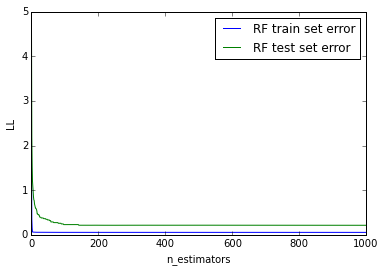

In [129]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=None, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [130]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=None, n_jobs=-1)
clf.fit(X_train_encoded, ytrain)

ypred = clf.predict_proba(X_test_encoded)[:, 1]

# Save predictions

In [133]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)